# SET UP 

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# read CSVs
movies = pd.read_csv('/Users/chris/Downloads/movies.csv')
ratings = pd.read_csv('/Users/chris/Downloads/ratings.csv')

# merge on movieId column
data = pd.merge(left=movies, right=ratings, on='movieId')

# DATA EXPLORATION

In [8]:
data.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,3.0,851866703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,9,4.0,938629179
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,13,5.0,1331380058
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.0,997938310
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,19,3.0,855190091


## EXPLORE PUBLISH YEAR

The publishing year is available in the title column, surrounded by brackets at the end of the title. For some movie that however is not the case, which makes the process of extraction a bit harder. So, the logic is as follows:
1. If publishing year is present, remove the brackets and keep integer representation of the year
2. Else, put 9999 as the year — an obvious indicator that year is missing

In [9]:
years = []

for title in data['title']:
    year_subset = title[-5:-1]
    try: years.append(int(year_subset))
    except: years.append(9999)
        
data['moviePubYear'] = years
print(len(data[data['moviePubYear'] == 9999])) 

9


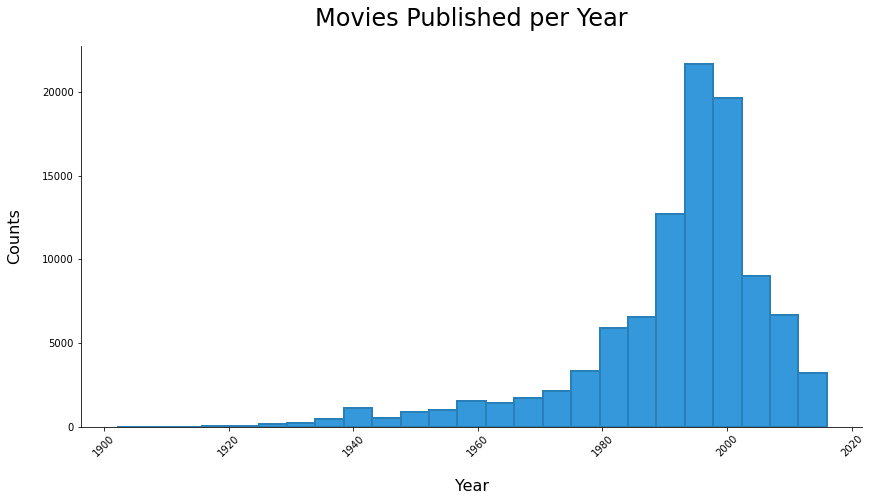

In [11]:
# there are 9 movies without publishing year, that isn't too bad. Let's plot a histogram.
def make_histogram(dataset, attribute, bins=25, bar_color='#3498db', edge_color='#2980b9', title='Title', xlab='X', ylab='Y', sort_index=False):
    if attribute == 'moviePubYear':
        dataset = dataset[dataset['moviePubYear'] != 9999]
        
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=24, pad=20)
    ax.set_xlabel(xlab, fontsize=16, labelpad=20)
    ax.set_ylabel(ylab, fontsize=16, labelpad=20)
    
    plt.hist(dataset[attribute], bins=bins, color=bar_color, ec=edge_color, linewidth=2)
    
    plt.xticks(rotation=45)
    
    
make_histogram(data, 'moviePubYear', title='Movies Published per Year', xlab='Year', ylab='Counts')
# Most movies in this dataset released around 2000.

## EXPLORE RATING

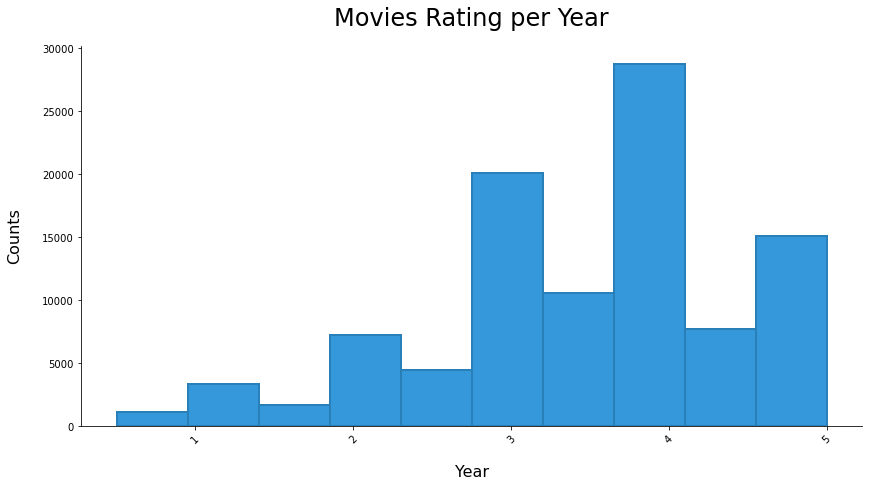

In [21]:
def make_histogram(dataset, attribute, bar_color='#3498db', edge_color='#2980b9', title='Title', xlab='X', ylab='Y', sort_index=False):
    if attribute == 'rating':  
        fig, ax = plt.subplots(figsize=(14, 7))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_title(title, fontsize=24, pad=20)
        ax.set_xlabel(xlab, fontsize=16, labelpad=20)
        ax.set_ylabel(ylab, fontsize=16, labelpad=20)

        plt.hist(dataset[attribute], color=bar_color, ec=edge_color, linewidth=2)

        plt.xticks(rotation=45)
    
    
make_histogram(data, 'rating', title='Movies Rating per Year', xlab='Year', ylab='Counts')
# Most movies in this dataset released around 2000.

## MOVIE GENRE EXPLORATION

In [22]:
data.head()

,movieId,title,genres,userId,rating,timestamp,moviePubYear
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,3.0,851866703,1995
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,9,4.0,938629179,1995
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,13,5.0,1331380058,1995
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.0,997938310,1995
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,19,3.0,855190091,1995


There’s no way to analyze it the way it currently is. What I want to accomplish is the following:
* Split the string on the pipe (|) character
* Create a new entry for each genre

So, 1 row of Adventure|Animation|Children|Comedy|Fantasy should become 5 rows.

In [23]:
genre_df = pd.DataFrame(data['genres'].str.split('|').tolist(), index=data['movieId']).stack()
genre_df = genre_df.reset_index([0, 'movieId'])
genre_df.columns = ['movieId', 'Genre']

In [24]:
genre_df

,movieId,Genre
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy
...,...,...
265512,162542,Thriller
265513,162672,Adventure
265514,162672,Drama
265515,162672,Romance


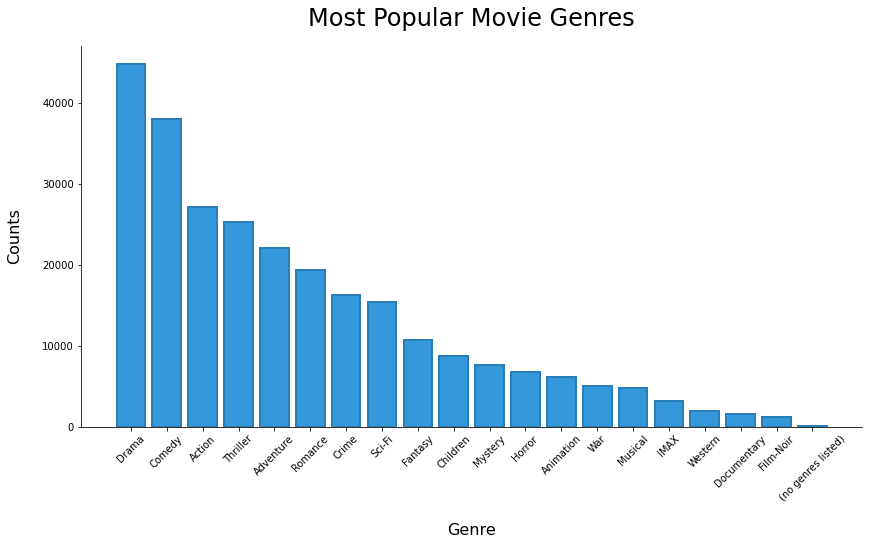

In [31]:
def make_bar_chart(dataset, attribute, bar_color='#3498db', edge_color='#2980b9', title='Title', xlab='X', ylab='Y', sort_index=False):
    if sort_index == False:
        xs = dataset[attribute].value_counts().index
        ys = dataset[attribute].value_counts().values
    else:
        xs = dataset[attribute].value_counts().sort_index().index
        ys = dataset[attribute].value_counts().sort_index().values
        
    
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=24, pad=20)
    ax.set_xlabel(xlab, fontsize=16, labelpad=20)
    ax.set_ylabel(ylab, fontsize=16, labelpad=20)
    
    plt.bar(x=xs, height=ys, color=bar_color, edgecolor=edge_color, linewidth=2)
    plt.xticks(rotation=45)
    
    
make_bar_chart(genre_df, 'Genre', title='Most Popular Movie Genres', xlab='Genre', ylab='Counts')
# Most movies are in drama or comedy category.

## CALCULATE RATINGS BY GENRE

You will need to:
1. Calculate the rating for each movie on individual genre level (genre string split by | )
2. Append a list of ratings for every genre to a dictionary
3. Calculate the average rating as the mean of the list in the dictionary

In [33]:
data.head(2)

,movieId,title,genres,userId,rating,timestamp,moviePubYear
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,3.0,851866703,1995
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,9,4.0,938629179,1995


In [32]:
# Both dictionary and defualtdict are almost same except for the fact that defualtdict never raises a KeyError. It provides a default value for the key that does not exist.
values = defaultdict(list)
for ind, row in data.iterrows():
    for genre in row['genres'].split('|'):
        values[genre].append(row['rating'])
        
        
genre_lst, rating_lst = [], []
for key, item in values.items():
    if key not in [0, 1]:
        genre_lst.append(key)
        rating_lst.append(np.mean(item))
        
        
genres_with_ratings = pd.DataFrame([genre_lst, rating_lst]).T
genres_with_ratings.columns = ['Genre', 'Mean_Rating']

In [38]:
genres_with_ratings

,Genre,Mean_Rating
0,Adventure,3.520393
1,Animation,3.636062
2,Children,3.466187
3,Comedy,3.446037
4,Fantasy,3.518063
5,Romance,3.556165
6,Drama,3.681780
7,Action,3.445613
8,Crime,3.679639
9,Thriller,3.518502


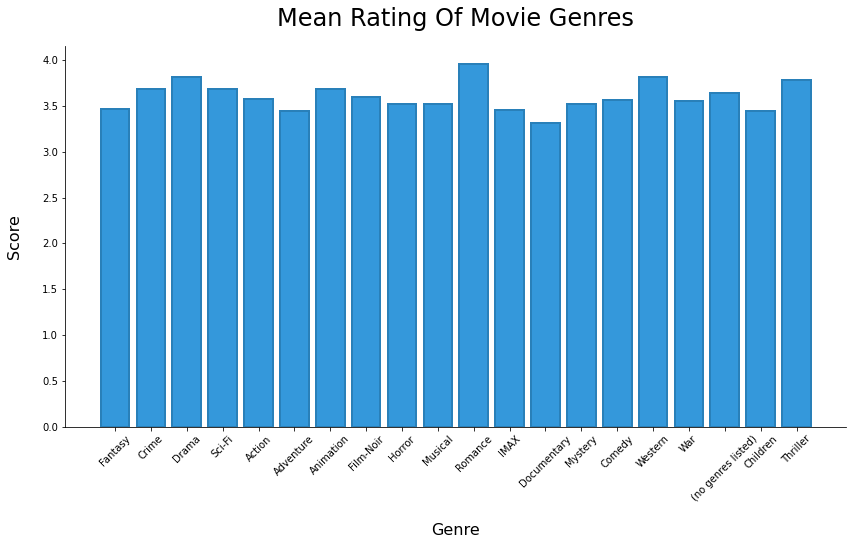

In [54]:
def make_bar_chart(dataset, xattribute, yattribute, bar_color='#3498db', edge_color='#2980b9', title='Title', xlab='X', ylab='Y', sort_index=False):
    if sort_index == False:
        xs = dataset[xattribute].value_counts().index
        ys = dataset[yattribute].value_counts().index
        
    
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=24, pad=20)
    ax.set_xlabel(xlab, fontsize=16, labelpad=20)
    ax.set_ylabel(ylab, fontsize=16, labelpad=20)
    
    plt.bar(x=ys, height=xs, color=bar_color, edgecolor=edge_color, linewidth=2)
    plt.xticks(rotation=45)
    
    
make_bar_chart(genres_with_ratings, 'Mean_Rating', 'Genre',title='Mean Rating Of Movie Genres', xlab='Genre', ylab='Score')


## VISUALIZE NUMBER OF RATINGS

You will have to:
* Create a DataFrame with movieId column grouped, and count the instances - (1)
* Merge it with the original dataset - (2)
* Rename columns that were messed up upon merging - (3)

In [59]:
num_ratings = pd.DataFrame(data.groupby('movieId').count()['rating']).reset_index() # (1)
data = pd.merge(left=data, right=num_ratings, on='movieId') # (2)
data.rename(columns={'rating_x': 'rating', 'rating_y': 'numRatings'}, inplace=True) # (3)

KeyError: 'rating'

In [62]:
# Before jumping into visualization, let’s take a look at the top 10 movies according to the number of ratings:
data.sort_values(by='numRatings', ascending=False).drop_duplicates('movieId')[:10]


,movieId,title,genres,userId,rating,timestamp,moviePubYear,numRatings
11118,356,Forrest Gump (1994),Comedy|Drama|Romance|War,197,3.0,975428956,1994,341
8901,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,478,5.0,1446621714,1994,324
9756,318,"Shawshank Redemption, The (1994)",Crime|Drama,502,5.0,861304067,1994,311
18228,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,479,5.0,1409004732,1991,304
7619,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,242,5.0,956684986,1977,291
14474,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,279,5.0,838231458,1993,274
51880,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,242,5.0,956684185,1999,259
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,3.0,851866703,1995,247
15689,527,Schindler's List (1993),Drama|War,169,5.0,1234228124,1993,244
17467,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,251,4.0,1476478052,1991,237


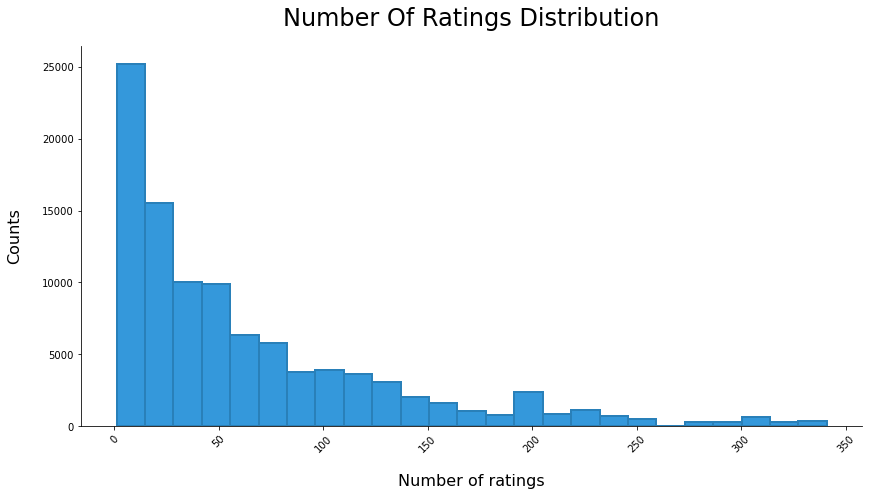

In [64]:
def make_histogram(dataset, attribute, bins=25, bar_color='#3498db', edge_color='#2980b9', title='Title', xlab='X', ylab='Y', sort_index=False):
    if attribute == 'numRatings':
        
        fig, ax = plt.subplots(figsize=(14, 7))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_title(title, fontsize=24, pad=20)
        ax.set_xlabel(xlab, fontsize=16, labelpad=20)
        ax.set_ylabel(ylab, fontsize=16, labelpad=20)

        plt.hist(dataset[attribute], bins=bins, color=bar_color, ec=edge_color, linewidth=2)

        plt.xticks(rotation=45)
    
    
make_histogram(data, 'numRatings', title='Number Of Ratings Distribution', xlab='Number of ratings', ylab='Counts')

## NUMBER OF RATINGS VS RATINGS

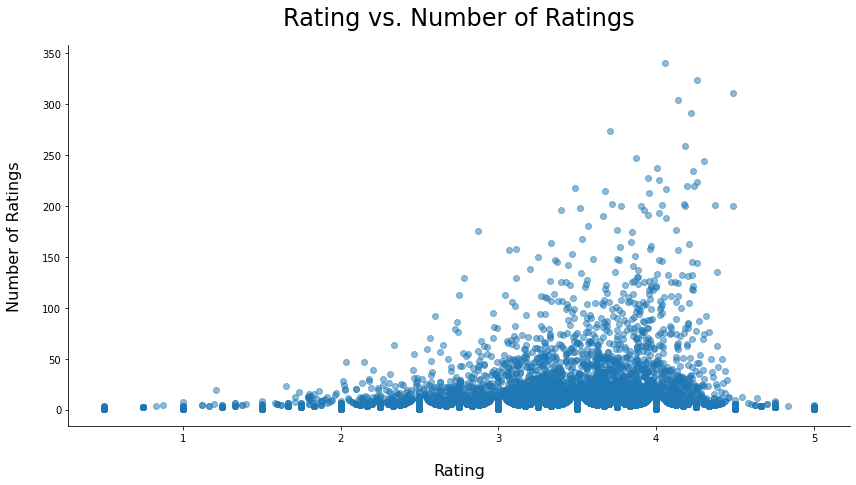

In [66]:
ratings_df = pd.DataFrame()
ratings_df['Mean_Rating'] = data.groupby('title')['rating'].mean().values
ratings_df['Num_Ratings'] = data.groupby('title')['rating'].count().values


fig, ax = plt.subplots(figsize=(14, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Rating vs. Number of Ratings', fontsize=24, pad=20)
ax.set_xlabel('Rating', fontsize=16, labelpad=20)
ax.set_ylabel('Number of Ratings', fontsize=16, labelpad=20)

plt.scatter(ratings_df['Mean_Rating'], ratings_df['Num_Ratings'], alpha=0.5)

You can see a trend here — as a movie gets more ratings it’s average ratings tends to increase. This also makes perfect sense if you think about it. If more and more people are watching a particular movie, it probably has a good budget and good marketing, which would mean that it’s a blockbuster of some sort, and they are generally highly rated.

# MATRIX CREATION

By matrix I mean that you should somehow create the table which has the following:
- Every user ID as a row
- Every movie title as a column
- Rating each user gave to each movie as the intersection of row and column

In [68]:
matrix = data.pivot_table(
    index='userId',
    columns='title',
    values='rating'
)

In [70]:
matrix.head()

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Why are there so many null values?** The reason is, not every person has seen and rated every movie. There are over 9700 movies in this table, so think about yourself. How many movies did you watch? Of those you watched, how many did you publicly rated? Not so many, right?

# CREATE A FUNCTION FOR FETCHING RECOMMENDATIONS

Here’s the logic you’ll have to implement:
* Calculate the correlation of the a (desired) movie with every other movie (using .corrwith() method) - (1)
* Store movie titles with correlations in separate DataFrame - (2)
* Merge that DataFrame with the original one, drop duplicates, and keep on the title, correlation coefficient, and the numRatings columns - (3)
* Sort by correlation in descending order (from largest to smallest correlation) - (4)
* Filter out movies that have a low number of ratings (those movies are irrelevant because they were seen only by a handful of people) - (5)
* Return top n correlated movies - (6)

In [71]:
def get_similar_movies(movie_title, n_ratings_filter=100, n_recommendations=5):
    similar = matrix.corrwith(matrix[movie_title]) # (1)
    corr_similar = pd.DataFrame(similar, columns=['correlation']) # (2)
    corr_similar.dropna(inplace=True)
    
    orig = data.copy()
    
    corr_with_movie = pd.merge( # (3), this is an inner join
        left=corr_similar, 
        right=orig, 
        on='title')[['title', 'correlation', 'numRatings']].drop_duplicates().reset_index(drop=True)
    # (4) & (5):
    result = corr_with_movie[corr_with_movie['numRatings'] > n_ratings_filter].sort_values(by='correlation', ascending=False)
    
    return result.head(n_recommendations) # (6)

# GET AND VALIDATE RESULTS

The only parameter you need to pass in is the movie title, and it has to be the same as the one present in the dataset, every little spelling mistake will break everything.

In [74]:
get_similar_movies('Toy Story (1995)')

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/chris/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,title,correlation,numRatings
4308,Toy Story (1995),1.000000,247
4309,Toy Story 2 (1999),0.743352,125
704,"Bug's Life, A (1998)",0.677299,105
2828,"Monsters, Inc. (2001)",0.549582,130
1050,"Dark Knight, The (2008)",0.540978,121


Take a look at what recommendations [IMDB](https://www.imdb.com/title/tt0114709/?ref_=fn_al_tt_1) gave for this movie. Cool, right?